In [502]:
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [58]:
def busca(df, *words):
    
    return df[np.logical_xor.reduce([df['Content'].str.contains(word) for word in words])]

news = pd.read_pickle('noticias.pkl')

news['Date'] = pd.to_datetime(news['Date'])
news=news.loc[(news['Date']> '2018-12-31') & (news['Date']< '2020-08-19')]
news = busca(news, 'bitcoin', 'Bitcoin')

news['weight'] = news['Views']/news.groupby('Date')['Views'].transform('sum')
news['value']=news['TBPolarity']*news['weight']

preco_btc = pd.read_csv('btcusd.csv', skiprows=1).sort_values(by='Date')

preco2019 = preco_btc[(pd.to_datetime(preco_btc['Date']).dt.year >= 2019)]
preco2019['Date']=pd.to_datetime(preco2019['Date'])

preco2019['std_test'] = preco2019['Close'].rolling(14).std()

preco2019['var_test'] = preco2019['Close'].rolling(14).var()

preco2019.head()

In [11]:
def newscorr(dado1, dado2):                                          #função que avalia o melhor número de dias de lag
    dummy=0                                                         #através da correlação entre os dados extraídos e os dados do btc
    max = 0                                                         #dado 1 começa a partir da i+1-ésima, logo é o dado que queremos prever
    for i in range(15):
        if i == 7:
            print("Lag de maior correlação:", max, " dias atrás")
            return 
        k=i+1
        h=i-7
        if i==0:
            print("Correlação com notícias do dia anterior:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        else:
            print("Correlação com notícias de ", 1+i, " dias atrás:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        if np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]>dummy:
            dummy = np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]
            max=i+1

In [12]:
newsagg = news.set_index('Date').groupby(pd.Grouper(freq='D')).sum()

idx = pd.date_range('01-01-2019', '08-17-2020')
newsagg = newsagg.reindex(idx, fill_value=0)

newsagg.reset_index(inplace=True)

newsagg['valor']=0

for i in range(np.shape(newsagg)[0]):
    if i == 12:
        newsagg.loc[i, 'valor'] = newsagg.loc[i, 'value']
    if i == 13:
        newsagg.loc[i, 'valor'] = newsagg.loc[i-1, 'value']/2
    elif i>13:
        newsagg.loc[i, 'valor'] = newsagg.loc[i, 'value'] + newsagg.loc[i-1, 'value']/2 + \
        newsagg.loc[i-2, 'value']/6 + newsagg.loc[i-3, 'value']/8 +newsagg.loc[i-4, 'value']/10 + \
        newsagg.loc[i-5, 'value']/12 + newsagg.loc[i-6, 'value']/14 + newsagg.loc[i-7, 'value']/16 + \
        newsagg.loc[i-8, 'value']/18 + newsagg.loc[i-9, 'value']/20 + newsagg.loc[i-10, 'value']/22 + \
        newsagg.loc[i-11, 'value']/24 + newsagg.loc[i-12, 'value']/26 + newsagg.loc[i-13, 'value']/28

newsagg.loc[newsagg["valor"] != 0].mean()

newsagg.loc[newsagg["valor"] == 0, 'valor'] = 0.088258

corr = pd.merge(left=preco2019, left_on='Date',
         right=newsagg, right_on='index')

corr = corr.round(4)

corr.describe().round(1)

In [847]:
def melhorMA(btc, dado, print_corr=False):
    maximum=0
    value=0
    x = np.arange(1,31,1)
    y=[]
    for i in range(30):
        lagged =  dado.rolling(window=i+1).mean().dropna()
        if np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1]>value:
            value = np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1]
            maximum=i+1
            
        y.append(np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1])
        
    if print_corr == True:
        
        print('correlations:',y)

    plt.figure(figsize=(25,5))
    plt.plot(x, y)
    plt.axvline(x=maximum, color ="green", linestyle =":")     
    print('max:',maximum, value)
    return

max: 16 0.4931539325731926


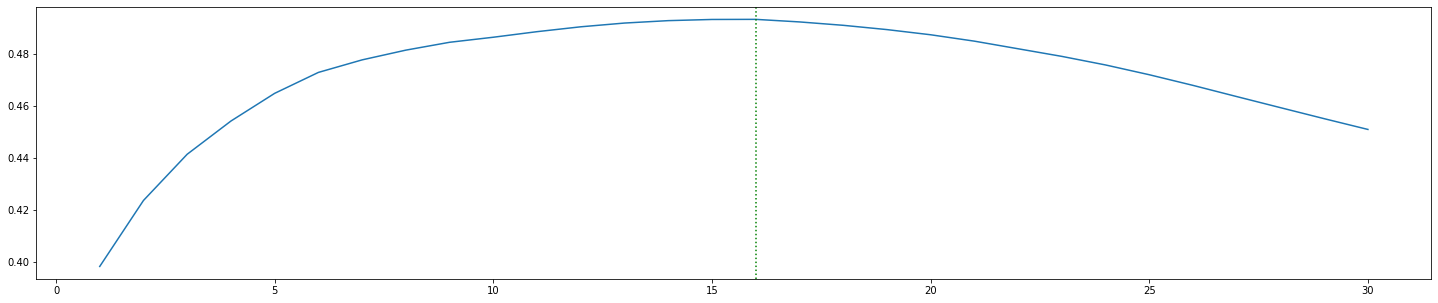

In [848]:
melhorMA(corr['Close'], corr['valor'])

In [72]:
def teste(noticias, precos):
    agregado = pd.merge(left=precos, left_on='Date',
         right=noticias, right_on='index')
    
    for i in range(7):
        medias = pd.DataFrame()

        medias['MA16']=agregado['valor'].rolling(window=16).mean().dropna()
        medias['MA4'] = agregado.loc[15-i:, 'valor'].rolling(window=i+1).mean().dropna()

        medias = medias.set_index(agregado.loc[15:, 'Date'])

        medias['posição'] = medias['MA4'] > medias['MA16']
        medias['anterior'] =  medias['posição'].shift(1)

        medias.dropna(inplace=True)

        medias['mudança'] = np.where(medias['posição'] == medias['anterior'], False, True)

        medias = medias.reset_index()

        medias['venda'] = np.where((medias['posição'] == False) & (medias['mudança'] == True), True, False)
        medias['compra'] = np.where((medias['posição'] == True) & (medias['mudança'] == True), True, False)
        
        print(lucro(agregado[16:], medias)[1], lucro(agregado[16:], medias)[2])

In [73]:
teste(newsagg, preco2019)

323.49336452920613 9246679.332873914
231.879791032121 4533511.684869937
367.47410686861906 11305045.038896207
446.4062012736712 17456743.2716406
157.34024364618648 8061391.053499197
219.88252611923664 10284768.445929939
214.80836945536979 11099461.394663803


In [499]:
medias = pd.DataFrame()

medias['MA16']= corr['Close'].rolling(window=16).mean().dropna()
medias['MA1'] = corr.loc[15:, 'Close'].rolling(window=1).mean().dropna()

medias = medias.set_index(corr.loc[15:, 'index'])

medias['posição']  = medias['MA1'] > medias['MA16']
medias['anterior'] =  medias['posição'].shift(1)

medias.dropna(inplace=True)

medias['mudança'] = np.where(medias['posição'] == medias['anterior'], False, True)

medias = medias.reset_index()

medias['venda']  = np.where((medias['posição'] == False) & (medias['mudança'] == True), True, False)
medias['compra'] = np.where((medias['posição'] == True) & (medias['mudança'] == True), True, False)

corr['teste'] = corr['valor'].rolling(window=20).mean().fillna(0)

In [849]:
def lucro_noticias_ORIGINAL(precos, decisao):
    inicio = True
    btc = 0
    primeiro = False
    caixa = 0
    investimento = 0
    valor = []
    dummy = 0
    start = 0
    buyprice = 1000000
    for i in range(len(precos)):
        if (inicio == True) & (decisao.loc[i, 'compra'] == True):
            inicio = False
            btc = 1
            primeiro = True
            start = i
            investimento = precos.loc[i+17, 'Open']
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == True):
            btc = 0
            primeiro = False
            caixa = precos.loc[i+17, 'Close']
        elif (inicio == False) & (decisao.loc[i, 'compra'] == True) & (primeiro == False) & (i<230):
            buyprice = precos.loc[i+17, 'Open']
            btc = btc + caixa/precos.loc[i+17, 'Open']
            caixa = max(caixa - btc*precos.loc[i+17, 'Open'], 0)
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == False) & (i<230):
            caixa = caixa + btc*precos.loc[i+17, 'Close']
            btc=0
        elif (inicio == False) & (decisao.loc[i, 'compra'] == True) & (i>=213):
            buyprice = precos.loc[i+17, 'Open']
            btc = btc + caixa/precos.loc[i+17, 'Open']*min(1 , 1+1(precos.loc[i+17, 'teste']-precos.loc[230:i+17, 'valor'].mean()))
            caixa = max(caixa - btc*precos.loc[i+17, 'Open'], 0)
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (i>=213):
            caixa = caixa + btc*precos.loc[i+17, 'Close']*min(1, 1+2(precos.loc[i+17, 'valor']-precos.loc[230:i+17, 'valor'].mean()))
            dummy = min(1, 1+2*(precos.loc[i+17, 'valor']-precos.loc[230:i+17, 'valor'].mean()))
            btc = btc*(1 - dummy)
        valor.append(caixa + btc*precos.loc[i+16, 'Close'])
   
    plt.figure(figsize=(25,5))

    plt.plot(precos.loc[16:, 'Close'].reset_index())
    plt.plot(valor)
    plt.show()
    
    return print('retorno: \t', 100*list(filter(None, valor))[-1]/investimento-100, '\n',
                 'variancia do modelo:\t', pd.Series(valor)[start:].std(), '\n',
                 'variancia do mercado:\t', precos['Close'][start:].std())

In [843]:
def lucro_noticias(precos, decisao):
    
    inicio = True
    btc = 0
    primeiro = False
    caixa = 0
    investimento = 0
    valor = []
    dummy = 0
    start = 0
    
    for i in range(len(precos)):
        
        if (inicio == True) & (decisao.loc[i, 'compra'] == True):
            
            inicio = False
            btc = 1
            primeiro = True
            start = i
            investimento = precos.loc[i+17, 'Open']
            
        elif (inicio == False) & (decisao.loc[i, 'compra'] == True) & (primeiro == False) & (i<230):
            
            buyprice = precos.loc[i+17, 'Open']
            btc = btc + caixa / precos.loc[i+17, 'Open']
            caixa = max(caixa - btc * precos.loc[i+17, 'Open'], 0)
            
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == True):
            
            btc = 0
            primeiro = False
            caixa = precos.loc[i+17, 'Close']
            
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == False) & (i<230):
            caixa = caixa + btc*precos.loc[i+17, 'Close']
            btc=0
#             vendendo = min(1, np.log((precos.loc[i+17, 'valor']**2)/precos.loc[0:i+17, 'valor'].std()))
#             caixa = caixa + btc * precos.loc[i+17, 'Close'] * vendendo
#             btc = btc * (1 - vendendo)
            
        elif (inicio == False) & (decisao.loc[i, 'compra'] == True) & (primeiro == False) & (i>=213):
            
            btc = btc + caixa/precos.loc[i+17, 'Open'] #* comprando
            caixa = max(caixa - btc * precos.loc[i+17, 'Open'], 0)
            
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == False) & (i>=213):
            
            vendendo = min(1, np.log((precos.loc[i+17, 'teste']**2)/precos.loc[230:i+17, 'teste'].std()))
            caixa = caixa + btc * precos.loc[i+17, 'Close'] * vendendo
            btc = btc * (1 - vendendo)
            
        valor.append(caixa + btc*precos.loc[i+16, 'Close'])
    
    ######################################################################################################
    #### results #########################################################################################
    ######################################################################################################

    precos['posicao'] = valor
    valores_df = precos[['index','posicao','Close']]
    valores_df.columns = ['index','posicao','BTCusd']
    df_medias = valores_df.melt('index', var_name='ativo', value_name='usd')
    df_medias_cv = pd.merge(decisao[['index','venda','compra']],
                            df_medias, how='left', on='index')

    plt.figure(figsize=(25,10))

    ax = sns.lineplot(x="index", y="usd", hue="ativo",
                      data=df_medias_cv)

    plt.scatter(df_medias_cv.loc[(df_medias_cv['compra'] == True) & (df_medias_cv['ativo'] == 'BTCusd'),
                                 'index'].values,
                df_medias_cv.loc[(df_medias_cv['compra'] == True) & (df_medias_cv['ativo'] == 'BTCusd'), 
                       'usd'].values,
                label='skitscat',
                color='green', s=40, marker="^")

    plt.scatter(df_medias_cv.loc[(df_medias_cv['venda'] == True) & (df_medias_cv['ativo'] == 'BTCusd'), 
                                 'index'].values,
                df_medias_cv.loc[(df_medias_cv['venda'] == True) & (df_medias_cv['ativo'] == 'BTCusd'), 
                       'usd'].values, 
                label='skitscat', 
                color='red', s=30, marker="v")

#     ax2 = ax.twinx()
#     ax2 = sns.lineplot(data=precos.loc[16:], x='index', y='teste', color='grey', alpha=.5)
    
    retorno_modelo  = 100*list(filter(None, valor))[-1]/investimento-100
    retorno_mercado = 100*list(filter(None, precos['Close']))[-1]/investimento-100
    retorno_perc    = (retorno_modelo/retorno_mercado - 1) *100
    
    def sharpe_ratio(df_preco):
    
        sharpe_ratio = df_preco.pct_change()

        sharpe_ratio = sharpe_ratio.diff()

        sharpe_ratio = sharpe_ratio.mean()/sharpe_ratio.std() * np.sqrt(365)
        
        return sharpe_ratio
    
    sharpe_modelo = sharpe_ratio(valores_df['posicao'][start:])
    sharpe_mercado= sharpe_ratio(precos['Close'][start:])
    
    return print('\n retorno: \t\t',       retorno_modelo,  '\n',
                 'retorno do mercado: \t', retorno_mercado, '\n',
                 'ganho %: \t\t',          retorno_perc,    '%\n',
                 'std do modelo: \t',      valores_df['posicao'][start:].std(), '\n',
                 'std do mercado:\t',      precos['Close'][start:].std(),       '\n', 
                 'sharpe modelo: \t',      sharpe_modelo, '\n', 
                 'sharpe mercado:\t',      sharpe_mercado)                                   


 retorno: 		 196.92499829545358 
 retorno do mercado: 	 226.12120375483158 
 ganho %: 		 -12.91175041285979 %
 std do modelo: 	 1880.8995119430906 
 std do mercado:	 2096.2340317730163 
 sharpe modelo: 	 -0.003908326763310274 
 sharpe mercado:	 -0.005328585167724962


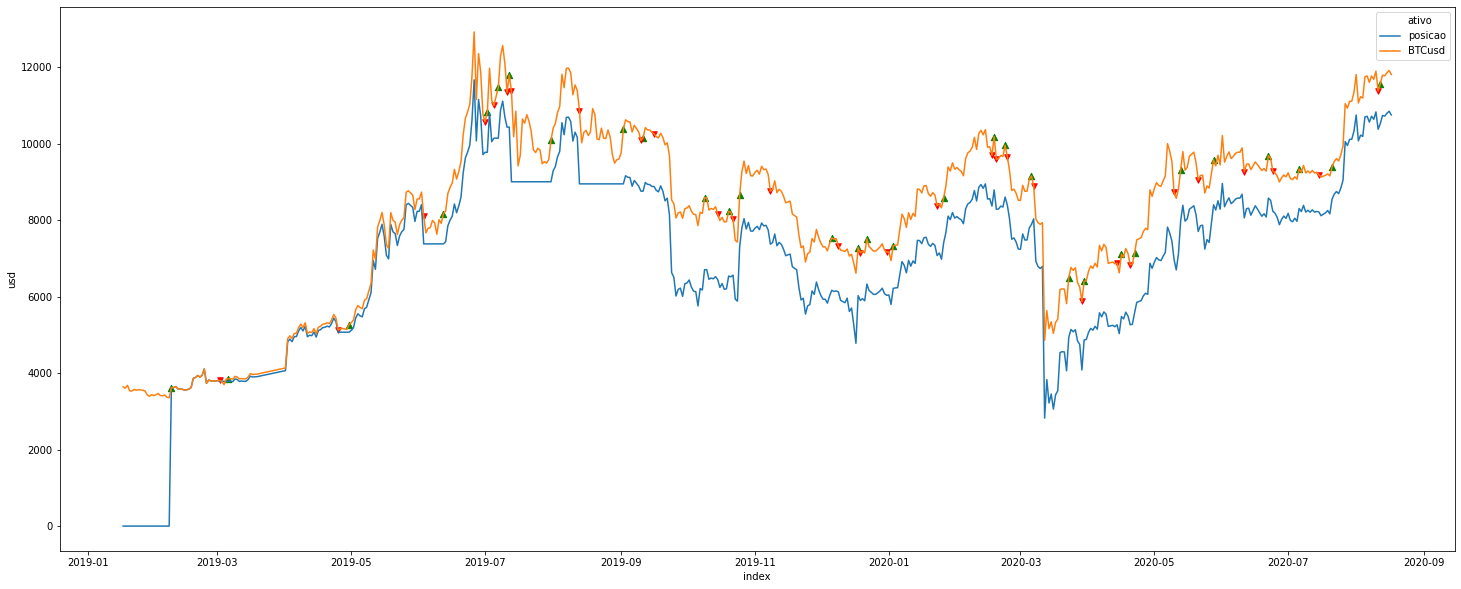

In [844]:
lucro_noticias(corr[16:], medias)

In [841]:
def lucro_noticias_arrojado(precos, decisao):
    
    inicio = True
    btc = 0
    primeiro = False
    caixa = 0
    investimento = 0
    valor = []
    dummy = 0
    start = 0
    
    for i in range(len(precos)):
        
        if (inicio == True) & (decisao.loc[i, 'compra'] == True):
            
            inicio = False
            btc = 1
            primeiro = True
            start = i
            investimento = precos.loc[i+17, 'Open']
            
        elif (inicio == False) & (decisao.loc[i, 'compra'] == True) & (primeiro == False): #& (i<230):
            
            buyprice = precos.loc[i+17, 'Open']
            btc = btc + caixa / precos.loc[i+17, 'Open']
            caixa = max(caixa - btc * precos.loc[i+17, 'Open'], 0)
            
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == True):
            
            btc = 0
            primeiro = False
            caixa = precos.loc[i+17, 'Close']
            
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == False):
            
            vendendo = min(1, np.log((precos.loc[i+17, 'valor']**2)/precos.loc[0:i+17, 'valor'].std())/10)
#             print(vendendo)
            caixa = caixa + btc * precos.loc[i+17, 'Close'] * vendendo
#             print(caixa)
            btc = btc * (1 - vendendo)
#             print(btc)
        valor.append(caixa + btc*precos.loc[i+16, 'Close'])
    
    ######################################################################################################
    #### results #########################################################################################
    ######################################################################################################

    precos['posicao'] = valor
    valores_df = precos[['index','posicao','Close']]
    valores_df.columns = ['index','posicao','BTCusd']
    df_medias = valores_df.melt('index', var_name='ativo', value_name='usd')
    df_medias_cv = pd.merge(decisao[['index','venda','compra']],
                            df_medias, how='left', on='index')

    plt.figure(figsize=(25,10))

    ax = sns.lineplot(x="index", y="usd", hue="ativo",
                      data=df_medias_cv)

    plt.scatter(df_medias_cv.loc[(df_medias_cv['compra'] == True) & (df_medias_cv['ativo'] == 'BTCusd'),
                                 'index'].values,
                df_medias_cv.loc[(df_medias_cv['compra'] == True) & (df_medias_cv['ativo'] == 'BTCusd'), 
                       'usd'].values,
                label='skitscat',
                color='green', s=40, marker="^")

    plt.scatter(df_medias_cv.loc[(df_medias_cv['venda'] == True) & (df_medias_cv['ativo'] == 'BTCusd'), 
                                 'index'].values,
                df_medias_cv.loc[(df_medias_cv['venda'] == True) & (df_medias_cv['ativo'] == 'BTCusd'), 
                       'usd'].values, 
                label='skitscat', 
                color='red', s=30, marker="v")

#     ax2 = ax.twinx()
#     ax2 = sns.lineplot(data=precos.loc[16:], x='index', y='teste', color='grey', alpha=.5)
    
    retorno_modelo  = 100*list(filter(None, valor))[-1]/investimento-100
    retorno_mercado = 100*list(filter(None, precos['Close']))[-1]/investimento-100
    retorno_perc    = (retorno_modelo/retorno_mercado - 1) *100
    
    def sharpe_ratio(df_preco):
    
        sharpe_ratio = df_preco.pct_change()

        sharpe_ratio = sharpe_ratio.diff()

        sharpe_ratio = sharpe_ratio.mean()/sharpe_ratio.std() * np.sqrt(365)
        
        return sharpe_ratio
    
    sharpe_modelo = sharpe_ratio(valores_df['posicao'][start:])
    sharpe_mercado= sharpe_ratio(precos['Close'][start:])
    
    return print('\n retorno: \t\t',       retorno_modelo,  '\n',
                 'retorno do mercado: \t', retorno_mercado, '\n',
                 'ganho %: \t\t',          retorno_perc,    '%\n',
                 'std do modelo: \t',      valores_df['posicao'][start:].std(), '\n',
                 'std do mercado:\t',      precos['Close'][start:].std(),       '\n', 
                 'sharpe modelo: \t',      sharpe_modelo, '\n', 
                 'sharpe mercado:\t',      sharpe_mercado)                                   


 retorno: 		 242.7098999734937 
 retorno do mercado: 	 226.12120375483158 
 ganho %: 		 7.336196669396888 %
 std do modelo: 	 2220.5884023301987 
 std do mercado:	 2096.2340317730163 
 sharpe modelo: 	 -0.0047703052864011075 
 sharpe mercado:	 -0.005328585167724962


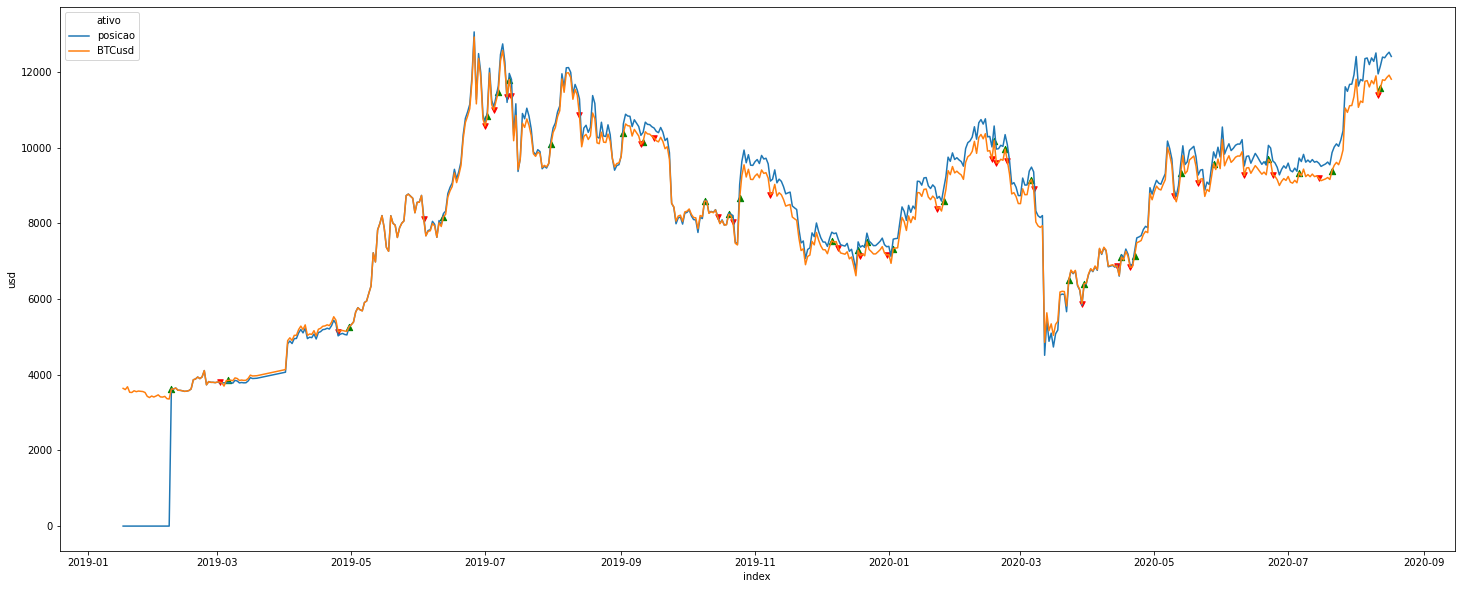

In [842]:
lucro_noticias_arrojado(corr[16:], medias)